# Create petab problem from SBML file
In this notebook we create the necessary files for a petab problem from a SBML file using the conversion reaction model as an example.

In [1]:
import libsbml
import importlib
import os
import sys
import shutil

import amici
import amici.plotting

import pandas as pd
import numpy as np

import petab
from petab.C import *


### Load and compile the model

In [2]:
# model name
model_name = "Spoegler_conversionReaction"

#sbml file we want to use
sbml_file = "Spoegler_conversionReaction.xml"

#output directory, to which generated model code is written
model_output_dir = "tmp/"+model_name

# model compilation
sbml_importer = amici.SbmlImporter(sbml_file)
sbml_importer.sbml2amici(model_name, model_output_dir, verbose=False)

# loading the model module
model_module = amici.import_model_module(model_name, model_output_dir)
model = model_module.getModel()
solver = model.getSolver()

# Have a look on the model
print("Model name:", model.getName())
print("Model parameters:", model.getParameterIds())
print("Model outputs:   ", model.getObservableIds())
print("Model states:    ", model.getStateIds())

Model name: Spoegler_conversionReaction
Model parameters: ('k1', 'k2', 'k3')
Model outputs:    ('yA', 'yB', 'yCell')
Model states:     ('A', 'B')


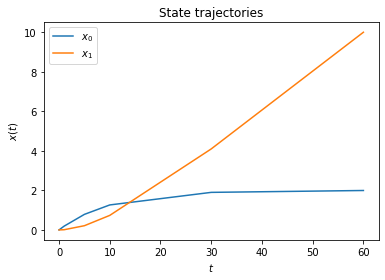

In [3]:
model.setTimepoints([0,1,5,10,30,60])

model.setParameterByName("k1", 0.2)
model.setParameterByName("k2", 0.1)
model.setParameterByName("k3", 0)

# Run simulation using default model parameters and solver options
rdata = amici.runAmiciSimulation(model, solver)

# get simulated data
simulations = rdata.x

# plot simulated trajectories
amici.plotting.plotStateTrajectories(rdata)




### Adding noise
To get some artifical noisy measuremtn data, we add normal noise to the simulation of the observable of interest, which is the second species.

In [4]:
times = [0,1,5,10,30,60]
nt = len(times)
sigma = 0.15
simulationsB = simulations.T[1]
measurementsB = simulationsB + sigma * np.random.randn(nt)
print(simulationsB)
print(measurementsB)

[0.00000000e+00 9.67483589e-03 2.13061321e-01 7.35758887e-01
 4.09957414e+00 1.00049575e+01]
[ 0.05157086 -0.16298155  0.20600331  0.71333279  4.37924788  9.92666106]


### Create PEtab files
Now we can create the PEtab files, where we specify the observable, add the noise as an extra parameter and specify the parameter scale.

In [5]:
# specify parameter scale
param_scale="lin"

condition_df = pd.DataFrame(
    data={
        CONDITION_ID: ['condition1'],
    }
).set_index([CONDITION_ID])

measurement_df = pd.DataFrame(
    data={
        OBSERVABLE_ID: ['observed_B'] * nt,
        SIMULATION_CONDITION_ID: ['condition1'] * nt,
        MEASUREMENT: measurementsB,
        TIME: times,
        NOISE_PARAMETERS: ['sd_observed_B'] * nt,
    }
)

observable_df = pd.DataFrame(
    data={
        OBSERVABLE_ID: ['observed_B'],
        OBSERVABLE_FORMULA: ['B'],
        NOISE_FORMULA: ['noiseParameter1_observed_B'],
        NOISE_DISTRIBUTION: ['normal'],
    }
).set_index([OBSERVABLE_ID])

parameter_df = pd.DataFrame(
    data={
        PARAMETER_ID: ['k1', 'k2', 'k3', 'sd_observed_B'],
        PARAMETER_SCALE: [param_scale] * 4,
        LOWER_BOUND: [-5] * 4,
        UPPER_BOUND: [3] * 4,
        NOMINAL_VALUE: [0.07918125, 0.04139269, 0, 0.17609126],
        ESTIMATE: [1] * 4,
    }
).set_index(PARAMETER_ID)

yaml_config = {
    FORMAT_VERSION: 1,
    PARAMETER_FILE: "parameters.tsv",
    PROBLEMS: [
        {
            SBML_FILES: ["Spoegler_conversionReaction.xml"],
            CONDITION_FILES: ["conditions.tsv"],
            MEASUREMENT_FILES: ["measurements.tsv"],
            OBSERVABLE_FILES: ["observables.tsv"],
        }
    ],
}

param_scale='log10_shift2'
# create folders for the scale and store the files
os.makedirs("petab/"+param_scale)
petab.write_condition_df(condition_df, "petab/"+param_scale+"/conditions.tsv")
petab.write_measurement_df(measurement_df, "petab/"+param_scale+"/measurements.tsv")
petab.write_observable_df(observable_df, "petab/"+param_scale+"/observables.tsv")
petab.write_parameter_df(parameter_df, "petab/"+param_scale+"/parameters.tsv")
petab.write_yaml(yaml_config, "petab/"+param_scale+"/Spoegler_conversionReaction.yaml")



In [6]:
# copy sbml file to same petab-folder
shutil.copy("Spoegler_conversionReaction.xml", "petab/"+param_scale+"/Spoegler_conversionReaction.xml")

'petab/log10_shift2/Spoegler_conversionReaction.xml'

In [7]:
# validate written PEtab files
problem = petab.Problem.from_yaml("petab/"+param_scale+"/Spoegler_conversionReaction.yaml")
petab.lint_problem(problem)

False